# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 139 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 31.2 MB/s eta 0:00:01
     |████████████████████████████████| 914 kB 71.9 MB/s eta 0:00:01


**Important: Restart the Kernel at this moment**

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
# transforms.Compose is used to apply multiple transformations sequentially as a pipeline:
# Image → ToTensor → Normalize → model
# This means that every image loaded from the MNIST dataset passes through each of these transformations one by one.
# transforms.ToTensor() converts the images to tensors
# Normalization rescales the input data by subtracting the dataset mean and dividing by the dataset standard deviation. 
# For MNIST, the values (0.1307, 0.3081) come from the training set statistics. This process centers the data around zero 
# and standardizes its scale, which leads to more stable gradients and faster, more reliable neural network training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create training set
# This code creates the MNIST training dataset, downloads it if necessary, applies the defined transforms to each image, 
# and prepares it for use in model training.
train_dataset = torchvision.datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transform
)

# Define training dataloader
# This DataLoader splits the training dataset into shuffled mini-batches of 64 samples, allowing the model to be trained 
# efficiently using batch-based gradient descent.
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

# Create test set
test_dataset = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transform  # same transform as training
)

# Define test dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**I applied two preprocessing steps: converting the images to tensors and normalizing them.
transforms.ToTensor() converts the MNIST images into PyTorch tensors and scales the pixel values from the range 0–255 to 0–1, which is required for neural network training.
transforms.Normalize((0.1307,), (0.3081,)) standardizes the input using the mean and standard deviation of the MNIST training set, centering the data around zero and ensuring a consistent scale. This normalization leads to more stable gradients, faster convergence, and more reliable training performance.**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
# Training set size
print(f"Training set size: {len(train_dataset)} images")
print(f"Each image shape: {train_dataset[0][0].shape}")  # after transforms, e.g., [1, 28, 28]

# Test set size
print(f"Test set size: {len(test_dataset)} images")
print(f"Each image shape: {test_dataset[0][0].shape}")

Training set size: 60000 images
Each image shape: torch.Size([1, 28, 28])
Test set size: 10000 images
Each image shape: torch.Size([1, 28, 28])


In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

8


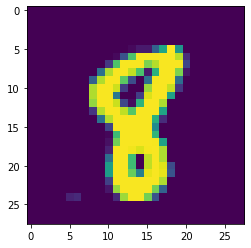

6


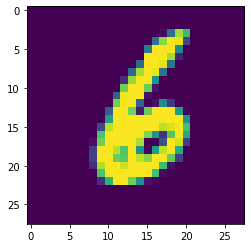

8


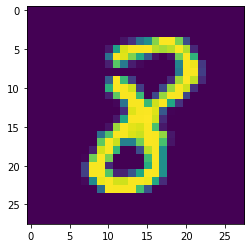

7


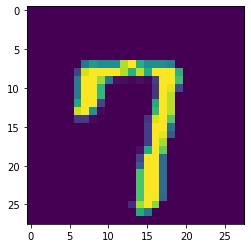

7


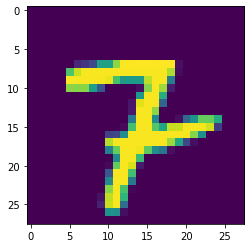

In [5]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Flatten layer: 28x28 -> 784
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc1 = nn.Linear(28*28, 128)   # Input -> Hidden layer 1
        self.fc2 = nn.Linear(128, 64)      # Hidden layer 1 -> Hidden layer 2
        self.fc3 = nn.Linear(64, 10)       # Hidden layer 2 -> Output layer (10 classes)
    
    def forward(self, x):
        x = self.flatten(x)           # Flatten input
        x = F.relu(self.fc1(x))       # Hidden layer 1 + ReLU
        x = F.relu(self.fc2(x))       # Hidden layer 2 + ReLU
        x = self.fc3(x)               # Output logits (no softmax needed with CrossEntropyLoss)
        return F.softmax(x, dim=1)   # output probabilities

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# Instantiate the model
model = MNISTNet()

# Define the loss function
# CrossEntropyLoss is standard for multi-class classification problems
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# Adam optimizer is chosen for faster convergence and adaptive learning rates
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to device
model.to(device)

# Number of epochs
num_epochs = 5

# Store average loss for each epoch
epoch_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        
        # Print loss every 250 batches
        if (batch_idx + 1) % 250 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}], Loss: {loss.item():.4f}")
    
    # Compute average loss for epoch
    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] finished, Average Loss: {avg_loss:.4f}\n")


Using device: cpu
Epoch [1/5], Batch [250], Loss: 1.5912
Epoch [1/5], Batch [500], Loss: 1.5609
Epoch [1/5], Batch [750], Loss: 1.5367
Epoch [1/5] finished, Average Loss: 1.5820

Epoch [2/5], Batch [250], Loss: 1.4902
Epoch [2/5], Batch [500], Loss: 1.5314
Epoch [2/5], Batch [750], Loss: 1.4974
Epoch [2/5] finished, Average Loss: 1.5203

Epoch [3/5], Batch [250], Loss: 1.5065
Epoch [3/5], Batch [500], Loss: 1.4692
Epoch [3/5], Batch [750], Loss: 1.4794
Epoch [3/5] finished, Average Loss: 1.5070

Epoch [4/5], Batch [250], Loss: 1.5094
Epoch [4/5], Batch [500], Loss: 1.5099
Epoch [4/5], Batch [750], Loss: 1.4941
Epoch [4/5] finished, Average Loss: 1.4989

Epoch [5/5], Batch [250], Loss: 1.5053
Epoch [5/5], Batch [500], Loss: 1.4855
Epoch [5/5], Batch [750], Loss: 1.5161
Epoch [5/5] finished, Average Loss: 1.4943



Plot the training loss (and validation loss/accuracy, if recorded).

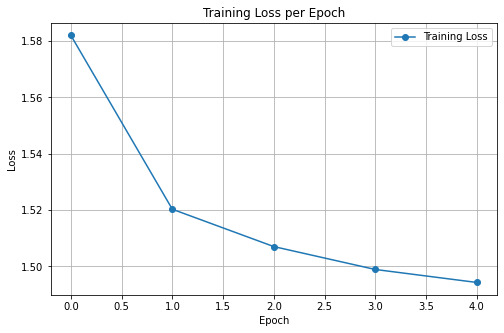

In [9]:
plt.figure(figsize=(8,5))
plt.plot(epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
# Set model to evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():  # No gradient needed for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)                  # Forward pass
        _, predicted = torch.max(outputs, 1)    # Get index of max logit = predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 96.93%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [12]:
# Compared to the original MNISTNet, the improved model has larger hidden layers (256→128→64), an extra hidden layer, 
# and Dropout(0.2) to reduce overfitting and improve generalization, while still flattening the input for the fully 
# connected layers.
    
class MNISTNetImproved(nn.Module):
    def __init__(self):
        super(MNISTNetImproved, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)   # more hidden layers
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)    # reduce overfitting
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)   # output probabilities

In [13]:
# -------------------------------
# Training & Testing MNISTNetImproved
# -------------------------------

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the improved model
model = MNISTNetImproved().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10  # Increase if needed

# Store average loss for each epoch
epoch_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        
        # Print loss every 250 batches
        if (batch_idx + 1) % 250 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}], Loss: {loss.item():.4f}")
    
    # Compute average loss for epoch
    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] finished, Average Loss: {avg_loss:.4f}\n")

Using device: cpu
Epoch [1/10], Batch [250], Loss: 1.6536
Epoch [1/10], Batch [500], Loss: 1.6099
Epoch [1/10], Batch [750], Loss: 1.5510
Epoch [1/10] finished, Average Loss: 1.6132

Epoch [2/10], Batch [250], Loss: 1.5291
Epoch [2/10], Batch [500], Loss: 1.5297
Epoch [2/10], Batch [750], Loss: 1.5078
Epoch [2/10] finished, Average Loss: 1.5271

Epoch [3/10], Batch [250], Loss: 1.4983
Epoch [3/10], Batch [500], Loss: 1.5257
Epoch [3/10], Batch [750], Loss: 1.4933
Epoch [3/10] finished, Average Loss: 1.5156

Epoch [4/10], Batch [250], Loss: 1.4987
Epoch [4/10], Batch [500], Loss: 1.5692
Epoch [4/10], Batch [750], Loss: 1.5221
Epoch [4/10] finished, Average Loss: 1.5099

Epoch [5/10], Batch [250], Loss: 1.4971
Epoch [5/10], Batch [500], Loss: 1.5130
Epoch [5/10], Batch [750], Loss: 1.5194
Epoch [5/10] finished, Average Loss: 1.5099

Epoch [6/10], Batch [250], Loss: 1.5368
Epoch [6/10], Batch [500], Loss: 1.5059
Epoch [6/10], Batch [750], Loss: 1.4993
Epoch [6/10] finished, Average Loss: 

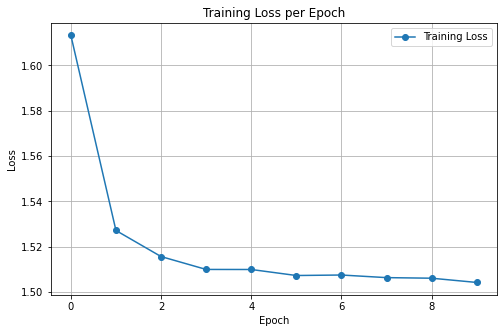

In [14]:
plt.figure(figsize=(8,5))
plt.plot(epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# -------------------------------
# Test Accuracy
# -------------------------------
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 96.24%


## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
# Path to save the model
save_path = "mnist_net_improved.pth"

# Save the entire model
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to mnist_net_improved.pth
